In [1]:
# default_exp capsAnalaysis

In [2]:
import sys

In [3]:
sys.path.append('/workspace/oct_ca_seg/oct/')

In [4]:
from oct.startup import *
from model import CapsNet
import numpy as np
import mlflow
from fastai.vision import *
import mlflow.pytorch as MLPY
from fastai.utils.mem import gpu_mem_get_all
from skimage import filters

In [5]:
gpu_mem_get_all()

[GPUMemory(total=16280, free=11957, used=4323),
 GPUMemory(total=16280, free=16270, used=10),
 GPUMemory(total=16280, free=16270, used=10),
 GPUMemory(total=16280, free=16270, used=10)]

In [6]:
cocodata_path = Path('/workspace/oct_ca_seg/COCOdata/')
train_path = cocodata_path/'train/images'
valid_path = cocodata_path/'valid/images'
test_path = cocodata_path/'test/images'

In [7]:
metrics = [sens, spec, dice, my_Dice_Loss, acc]

In [8]:
runsave_dir = Path('/workspace/oct_ca_seg/runsaves/')

In [9]:
run_name = 'DEEPCAP_09start_10e_001lr_fsmooth_upsample' #best
cfg_file = 'DEEPCAP_09start_10e_001lr_fsmooth_upsample'

In [10]:
run_dir = runsave_dir/run_name

In [11]:
def loadConfigRun(run_dir, name):
    with open(run_dir/name, 'r') as file:
        return json.load(file)

In [12]:
cfg_dict = loadConfigRun(run_dir, cfg_file)

In [13]:
#cfg_dict['LEARNER']['bs'] = 1

In [14]:
config = DeepConfig(cfg_dict)

## Train, Valid

In [20]:
fn_get_y = lambda image_name: Path(image_name).parent.parent/('labels/'+Path(image_name).name)
codes = np.loadtxt(cocodata_path/'codes.txt', dtype=str)
tfms = get_transforms()
src = (SegCustomItemList
       .from_folder(cocodata_path, recurse=True, extensions='.jpg')
       .filter_by_func(lambda fname: Path(fname).parent.name == 'images', )
       .split_by_folder('train', 'valid')
       .label_from_func(fn_get_y, classes=codes))
src.transform(tfms, tfm_y=True, size=config.LEARNER.img_size)
data = src.databunch(cocodata_path,
                     bs=config.LEARNER.bs,
                     val_bs=2*config.LEARNER.bs,
                     num_workers = config.LEARNER.num_workers)
stats = [torch.tensor([0.2190, 0.1984, 0.1928]), torch.tensor([0.0645, 0.0473, 0.0434])]
data.normalize(stats);
data.c_in, data.c_out = 3, 2

In [22]:
len(data.train_ds)/12011

0.7078511364582466

In [23]:
len(data.valid_ds)/12011

0.20805927899425528

## Test

In [15]:
def _in_delta(x):
    #print(x.shape)
    return x[config.MODEL.input_images,:,:]
in_delta = TfmPixel(_in_delta, order=0)
in_delta.use_on_y = False

In [16]:
fn_get_y = lambda image_name: Path(image_name).parent.parent/('labels/'+Path(image_name).name)
codes = np.loadtxt(cocodata_path/'codes.txt', dtype=str)
tfms = get_transforms()
tfms[0].append(in_delta())
tfms[1].append(in_delta())
src = (SegCustomItemList
       .from_folder(test_path, recurse=True, extensions='.jpg')
       .filter_by_func(lambda fname: Path(fname).parent.name == 'images', )
       .split_by_rand_pct(0.90)
       .label_from_func(fn_get_y, classes=codes))
src.transform(tfms, tfm_y=True, size =config.LEARNER.img_size)
data = src.databunch(test_path,
                     bs=config.LEARNER.bs,
                     val_bs=2*config.LEARNER.bs,
                     num_workers = config.LEARNER.num_workers)
#stats = [torch.tensor([0.2190, 0.1984, 0.1928]), torch.tensor([0.0645, 0.0473, 0.0434])]
stats = data.batch_stats()
data.normalize(stats);
data.c_in, data.c_out = config.MODEL.inputchannels, 2

## Load Model

In [17]:
deepCap = CapsNet(config.MODEL).cuda()
learn = Learner(data = data,
                  model = deepCap,
                  metrics = metrics)

### LR finder

In [ ]:
lr_find(learn)

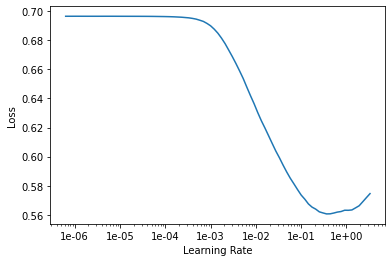

In [24]:
learn.recorder.plot()

## Run Analysis

In [18]:
learn = learn.load(run_dir/'learner')

In [19]:
learn.summary()

CapsNet
Layer (type)         Output Shape         Param #    Trainable 
ReLU                 [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [32, 128, 128]       2,432      True      
______________________________________________________________________
Conv2d               [64, 64, 64]         51,264     True      
______________________________________________________________________
Conv2d               [32, 64, 64]         18,464     True      
______________________________________________________________________
Softmax              [4, 64, 64, 4]       0          False     
______________________________________________________________________
Conv2d               [32, 32, 32]         9,248      True      
______________________________________________________________________
Softmax              [4, 32, 32, 4]       0          False     
______________________________________________________

In [20]:
class Analysis():
    def __init__(self, learner:Learner, run_dir:Path):
        self.learner = learner
        self.run_dir = run_dir
        self.metrics = pd.read_json(self.run_dir/'metrics.json')
        self.trainL =  pd.read_json(self.run_dir/'trainL.json')
        self.validL =  pd.read_json(self.run_dir/'validL.json')
    
    def remove0FromMetric(self, metric):
        zero_dict = {k:v for (k,v) in self.results[metric].items() if v==0}
        zero_dict = {k: v for k, v in sorted(zero_dict.items(), key=lambda item: item[1])}
        new_dict = {k:v for (k,v) in self.results[metric].items() if v!=0}
        new_dict = {k: v for k, v in sorted(new_dict.items(), key=lambda item: item[1])}
        print('there were ', len(zero_dict.keys()), 'zeros in the ', metric,' list.')
        return zero_dict, new_dict
    
    def histPlotMetric(self, metric, save=False):
        #metric = one of 'dices', 'sens', 'specs', 'accs' 
        zeros, actual = self.remove0FromMetric(metric)
        l_actual = list(actual.values())
        l_actual = [x for x in l_actual if x==x] # get rid of nans
        mean, std, median, max, min = np.mean(l_actual), np.std(l_actual), np.median(l_actual), np.max(l_actual), np.min(l_actual)
        print(mean, std, median, max, min)
        plt.hist(l_actual)
        if save: plt.savefig(self.checkpoint_path/(metric+'.png'))
        #return l_actual
    
    def showPrediction(self, id):
        self.learner.model.eval()
        batch = self.learner.data.one_batch(ds_type=DatasetType.Valid, denorm=False, detach=True, cpu=False)
        img = self.learner.data.one_batch(ds_type=DatasetType.Valid, denorm=True, detach=True, cpu=True)[0]
        xb = batch[0][id]#.permute(1,2,0).cpu()
        yb = batch[1][id][0]#.permute(1,2,0).cpu()
        pb = self.learner.model(xb.unsqueeze(0).cuda())[0]
        #print(xb.size(), yb.size(), pb.size())
        fig, (axim, axl, axp) = plt.subplots(nrows=1, ncols=3, figsize=(16, 3.5),
                    subplot_kw={'xticks': [], 'yticks': []})
        #images
        im = axim.imshow(img[id].permute(1,2,0)[:,:,0])
        axim.set_title('Image')
        l = axl.imshow(yb.cpu())
        axl.set_title('Label')
        p = axp.imshow(torch.argmax(pb.detach().cpu(), dim=0))
        print()
        axp.set_title('Pred')
        
        #return xb.size(), yb.size(), pb.size()

In [21]:
CapsAnalysis = Analysis(learn, run_dir)

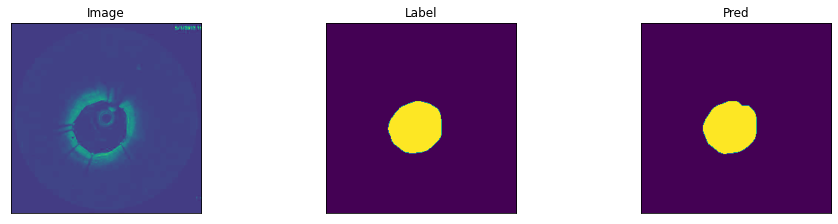

In [22]:
CapsAnalysis.showPrediction(10)

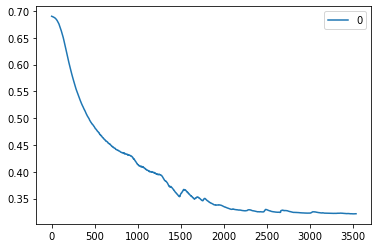

In [23]:
CapsAnalysis.trainL.sort_index().plot.line()

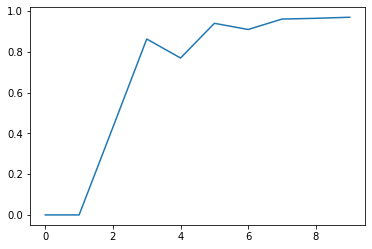

In [24]:
CapsAnalysis.metrics['dice'].sort_index().plot.line()

In [25]:
CapsAnalysis.metrics;

## test loop

In [26]:
learn.model.eval();

In [27]:
learn.model.cpu()

CapsNet(
  (get_prim_caps): Get_Primary_Caps(
    (relu): ReLU()
    (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  )
  (get_abstract_caps1): Get_Abstract_Caps_Down(
    (capsconv2d_down): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (routing): Agreement_Routing_Down(
      (softmax): Softmax(dim=-1)
    )
  )
  (get_abstract_caps1a): Get_Abstract_Caps_Down(
    (capsconv2d_down): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (routing): Agreement_Routing_Down(
      (softmax): Softmax(dim=-1)
    )
  )
  (get_abstract_caps2): Get_Abstract_Caps_Down(
    (capsconv2d_down): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (routing): Agreement_Routing_Down(
      (softmax): Softmax(dim=-1)
    )
  )
  (get_abstract_caps2a): Get_Abstract_Caps_Down(
    (capsconv2d_down): Conv2d(128, 128, kernel_size=(3, 3), stride

In [28]:
xb,yb=data.one_batch(ds_type=DatasetType.Valid , denorm=False,cpu=True)

In [29]:
%%timeit 
pb = learn.model(xb)

1.9 s ± 65 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
xb.size()

torch.Size([48, 3, 256, 256])

In [31]:
learn.model.eval();

In [35]:
1.9/48

0.03958333333333333

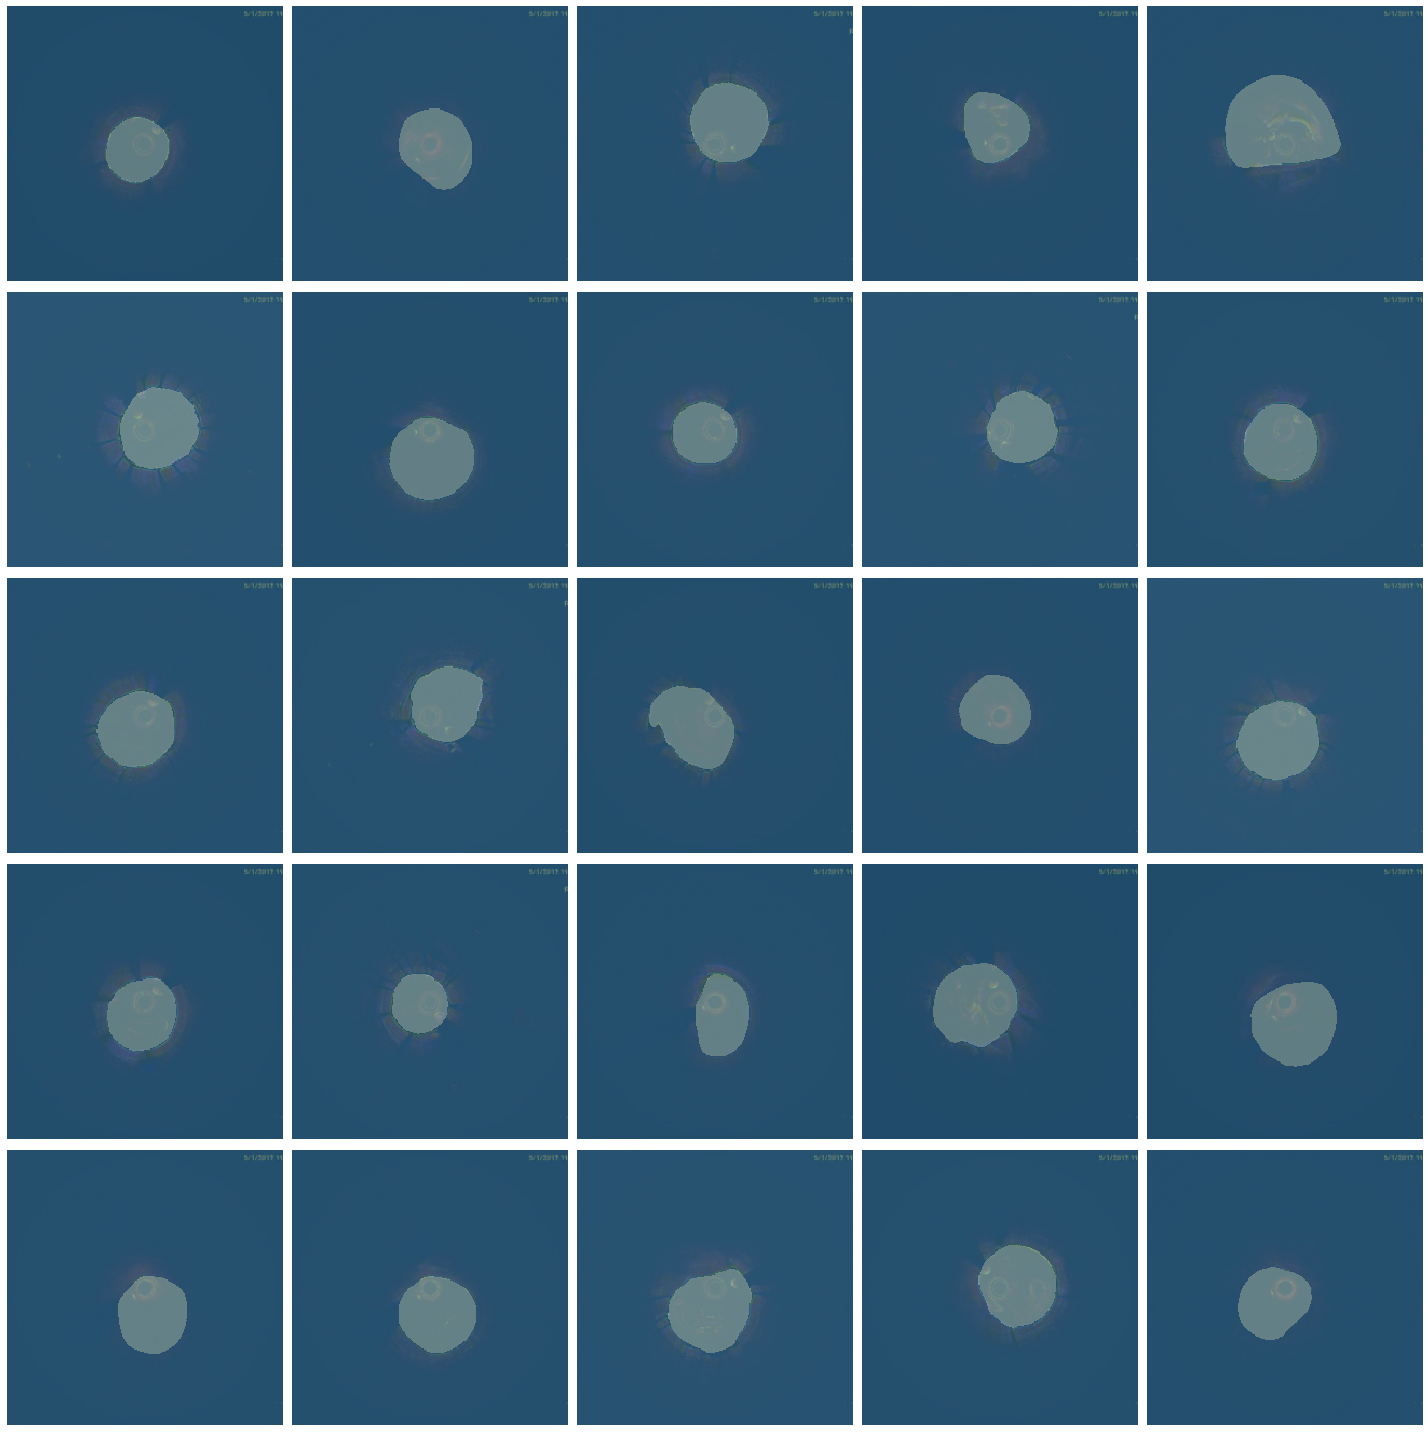

In [33]:
data.show_batch(ds_type=DatasetType.Valid)

In [34]:
deepCap = CapsNet(config.MODEL).cuda()
learn = Learner(data = data,
                  model = deepCap,
                  metrics = metrics)

In [36]:
learn = learn.load(run_dir/'learner')

In [37]:
learn.model.eval();

In [38]:
learn.model.cuda();

In [39]:
%%time
preds,targs = learn.get_preds()

CPU times: user 8.9 s, sys: 1.96 s, total: 10.9 s
Wall time: 11.8 s


In [40]:
12.9/15.8

0.8164556962025317

In [41]:
preds.size(), targs.size()

(torch.Size([909, 2, 256, 256]), torch.Size([909, 1, 256, 256]))

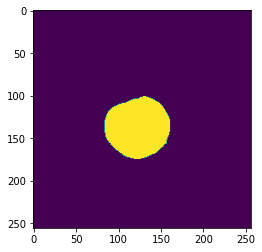

In [42]:
plt.imshow(targs[100,0])

(<matplotlib.image.AxesImage at 0x2b2d27fd7310>, 0.8996200561523438)

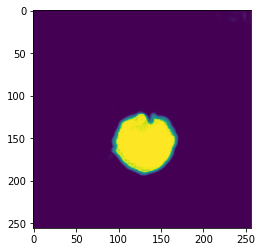

In [43]:
n = 108
plt.imshow(preds[n,1]), dice(preds[n].unsqueeze(0), targs[n].unsqueeze(0)).item()

In [44]:
%%time
recorder = []
for p,y in iter(zip(preds,targs)): 
    p = p.unsqueeze(0)
    y = y.unsqueeze(0)
    recorder.append([met(p, y).item() for met in metrics])

CPU times: user 41min 15s, sys: 6.73 s, total: 41min 21s
Wall time: 1min 28s


In [45]:
test_results = pd.DataFrame(recorder, columns=[met.__name__ for met in learn.metrics])

In [46]:
test_results.mean(axis=0)

sens            0.913568
spec            0.994143
dice            0.950613
my_Dice_Loss    0.879837
acc             0.035721
dtype: float64

In [47]:
test_results.std(axis=0)

sens            0.108948
spec            0.008973
dice            0.074628
my_Dice_Loss    0.029621
acc             0.000000
dtype: float64

In [48]:
test_results.median(axis=0)

sens            0.953091
spec            0.997030
dice            0.975982
my_Dice_Loss    0.878911
acc             0.035721
dtype: float64

In [49]:
test_results.min(axis=0)

sens            0.318832
spec            0.924043
dice            0.483507
my_Dice_Loss    0.796850
acc             0.035721
dtype: float64

In [50]:
test_results.max(axis=0)

sens            0.984148
spec            0.999300
dice            0.992010
my_Dice_Loss    0.945615
acc             0.035721
dtype: float64

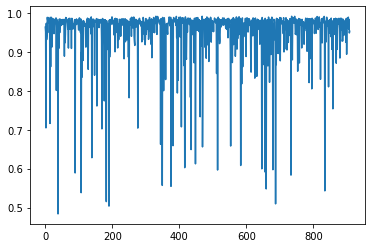

In [51]:
test_results['dice'].plot.line()

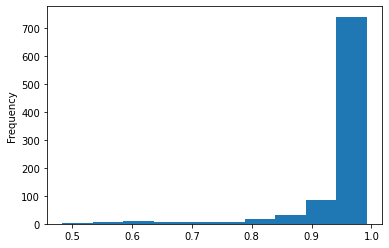

In [52]:
test_results['dice'].plot.hist()

In [53]:
test_results.to_json(run_dir/'test_results.json')

In [54]:
test_results.sort_values(by='dice')

,sens,spec,dice,my_Dice_Loss,acc
38,0.318832,0.924043,0.483507,0.800501,0.035721
190,0.336590,0.965201,0.503654,0.897151,0.035721
687,0.341748,0.927763,0.509408,0.803789,0.035721
182,0.346962,0.927617,0.515177,0.802211,0.035721
107,0.368127,0.962915,0.538148,0.895839,0.035721
...,...,...,...,...,...
391,0.983277,0.998062,0.991568,0.808116,0.035721
744,0.983592,0.999116,0.991728,0.896346,0.035721
735,0.983977,0.999300,0.991924,0.915202,0.035721
468,0.983992,0.998464,0.991931,0.838297,0.035721


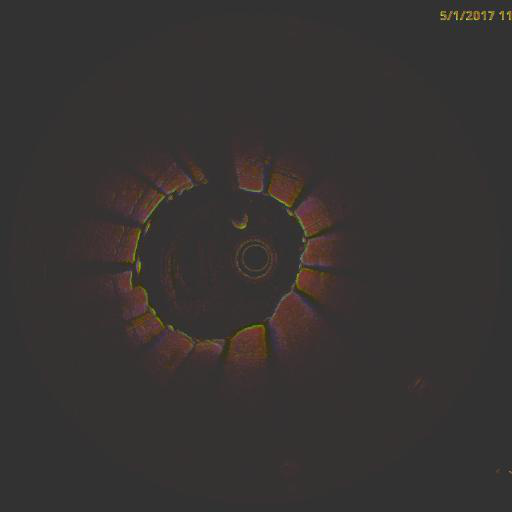

In [55]:
learn.data.valid_ds.x[111]

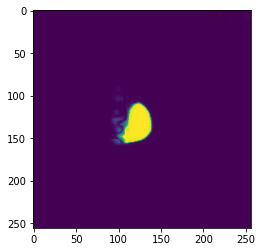

In [85]:
plt.imshow(preds[111][1])

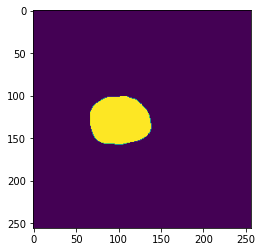

In [86]:
plt.imshow(targs[111][0])

In [166]:
learn.validate(metrics=metrics)

[0.31771377,
 tensor(0.9490),
 tensor(0.9965),
 tensor(0.9725),
 tensor(-4.5412),
 tensor(0.9404)]